In [2]:
import sys
sys.path.append("/usr/local/EnergyPlus-24-1-0")
from pyenergyplus.api import EnergyPlusAPI
import matplotlib.pyplot as plt
import threading
import traceback

In [14]:
class Simulation:
    def __init__(self):
        self.api = EnergyPlusAPI()
        self.state = self.api.state_manager.new_state()
        
        self.zone_temperature_setpoint = 20.0 
        self.temperature_tolerance = 0.5 
        self.current_zone_temps = {}
        
        self.warmup_count = 0
        self.total_warmups = 3
        self.done_warmup = False
        self.get_handle_done = False

        self.min_supply_temp = 15.0  
        self.max_supply_temp = 40.0 

        self.zone_names = ["Core_Zn"] + [f"Perimeter_Zn_{i}" for i in range(1, 5)]

        self.memory = {
            "zone_temperature": {zone: [] for zone in self.zone_names},
            "supply_air_temperature": {zone: [] for zone in self.zone_names},
            "supply_air_flow_rate": {zone: [] for zone in self.zone_names},
            "pmv": {zone: [] for zone in self.zone_names},
            "hvac_energy": [],
            "heating_energy": [],
            "cooling_energy": [],
            "fan_energy": [],
            "outdoor_temperature": []
        }

    
    def get_actuator_handle(self):

        # 0: Uncontrolled, 4: Dual setpoint
        self.thermostat_control_handle = self.api.exchange.get_actuator_handle(
            self.state,
            component_type="Schedule:Compact",
            control_type="Schedule Value",
            actuator_key="Dual Zone Control Type Sched" 
        )

        self.cooling_sp_handles = {
            zone: self.api.exchange.get_actuator_handle(
                self.state,
                component_type="Schedule:Compact",
                control_type="Schedule Value",
                actuator_key=f"{zone}_CLGSETP_SCH"
            ) for zone in self.zone_names
        }
        
        self.heating_sp_handles = {
            zone: self.api.exchange.get_actuator_handle(
                self.state,
                component_type="Schedule:Compact",
                control_type="Schedule Value",
                actuator_key=f"{zone}_HTGSETP_SCH"
        ) for zone in self.zone_names
        }

        print("actuator handles")
        print(self.heating_sp_handles)
        print(self.cooling_sp_handles)

    def get_variable_handle(self):
        self.zone_temperature_handles = {
            zone: self.api.exchange.get_variable_handle(
                self.state,
                "Zone Mean Air Temperature", 
                zone
            ) for zone in self.zone_names
        }
        
        self.pmv_handles = {
            zone: self.api.exchange.get_variable_handle(
                self.state,
                "Zone Thermal Comfort Fanger Model PMV",
                zone
            ) for zone in self.zone_names
        }
        
        self.outlet_node_temperature_handle ={
            zone: self.api.exchange.get_variable_handle(
            self.state,
            "System Node Temperature",
            f"PSZ-AC:{i+1} Supply Equipment Outlet Node"
        ) for (i, zone) in enumerate(self.zone_names)
        }

        self.mass_flow_handle = {
            zone: self.api.exchange.get_variable_handle(
            self.state,
            "System Node Mass Flow Rate",
            f"PSZ-AC:{i+1} Supply Equipment Outlet Node" 
        ) for (i, zone) in enumerate(self.zone_names)
        }

        self.outdoor_temp_handle = self.api.exchange.get_variable_handle(
                self.state,
                variable_name="Site Outdoor Air Drybulb Temperature",
                variable_key="Environment"
            )
        
        self.hvac_energy_handle = self.api.exchange.get_meter_handle(self.state, "Electricity:HVAC")
        self.heating_energy_handle = self.api.exchange.get_meter_handle(self.state, "Heating:Electricity")
        self.cooling_energy_handle = self.api.exchange.get_meter_handle(self.state, "Cooling:Electricity")
        self.fan_energy_handle = self.api.exchange.get_meter_handle(self.state, "Fans:Electricity")

    
    def get_handles(self):
        if not self.get_handle_done:
            self.get_actuator_handle()
            self.get_variable_handle()
            self.get_handle_done = True

    def run(self, building: str, weather: str, results_path: str):
        def callback_warm_up(state):
            self.warmup_count += 1
            self.done_warmup = (self.warmup_count >= self.total_warmups)
            print(f"Warm-up iteration {self.warmup_count} - Warm-up done: {self.done_warmup}")

        def callback_end_timestep(state):
            if self.done_warmup:
                self.get_handles()
                
                for zone in self.zone_names:
                    zone_temp = self.api.exchange.get_variable_value(state, self.zone_temperature_handles[zone])
                    pmv = self.api.exchange.get_variable_value(state, self.pmv_handles[zone])
                    supply_air_temperature = self.api.exchange.get_variable_value(state, self.outlet_node_temperature_handle[zone])
                    supply_air_flow_rate = self.api.exchange.get_variable_value(state, self.mass_flow_handle[zone])
                    self.current_zone_temps[zone] = zone_temp
                    self.memory["zone_temperature"][zone].append(zone_temp)
                    self.memory["pmv"][zone].append(pmv)
                    self.memory["supply_air_temperature"][zone].append(supply_air_temperature)
                    self.memory["supply_air_flow_rate"][zone].append(supply_air_flow_rate)

                outdoor_temperature = self.api.exchange.get_variable_value(state, self.outdoor_temp_handle)
                
                # Energy meters                
                hvac_energy = self.api.exchange.get_meter_value(state, self.hvac_energy_handle) / 3600  # Convert to Wh
                heating_energy = self.api.exchange.get_meter_value(state, self.heating_energy_handle) / 3600  # Convert to Wh
                cooling_energy = self.api.exchange.get_meter_value(state, self.cooling_energy_handle) / 3600  # Convert to Wh
                fan_energy = self.api.exchange.get_meter_value(state, self.fan_energy_handle) / 3600  # Convert to Wh

                # Update memory
                self.memory["hvac_energy"].append(hvac_energy)
                self.memory["heating_energy"].append(heating_energy)
                self.memory["cooling_energy"].append(cooling_energy)
                self.memory["fan_energy"].append(fan_energy)
                self.memory["outdoor_temperature"].append(outdoor_temperature)

        def callback_start_timestep(state):
            if self.done_warmup:
                self.get_handles()

                # Turn zones to uncontrolled
                # self.api.exchange.set_actuator_value(state, self.thermostat_control_handle, 0)

                for i, zone in enumerate(self.zone_names):                                       

                    cooling_sp = 25.0
                    heating_sp = 21.0
                    self.api.exchange.set_actuator_value(state, self.cooling_sp_handles[zone], cooling_sp)
                    self.api.exchange.set_actuator_value(state, self.heating_sp_handles[zone], heating_sp)

        self.api.runtime.callback_after_new_environment_warmup_complete(self.state, callback_warm_up)
        self.api.runtime.callback_end_zone_timestep_after_zone_reporting(self.state, callback_end_timestep)
        self.api.runtime.callback_begin_system_timestep_before_predictor(self.state, callback_start_timestep)

        
        def eplus_thread():
            try:
                exit_code = self.api.runtime.run_energyplus(
                    self.state,
                    command_line_args=['-d', results_path, '-w', weather, building]
                )
                print(f"EnergyPlus finished with exit code {exit_code}")

                if exit_code != 0:
                    print("Critical error in EnergyPlus! Stopping execution.")
                    sys.exit(1)
            except Exception as e:
                print(f"EnergyPlus Simulation Error: {e}")
                traceback.print_exc()

        thread = threading.Thread(target=eplus_thread, daemon=True)
        thread.start()
        

    
    def plot_supply_air(self, zone):
        timesteps = range(len(self.memory["supply_air_temperature"][zone]))
    
        fig, ax1 = plt.subplots(figsize=(15, 8))
    
        # Plot supply air temperature on the primary y-axis
        ax1.plot(timesteps, self.memory["supply_air_temperature"][zone], color="tab:blue", label="Supply Air Temperature (°C)")
        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("Supply Air Temperature (°C)", color="tab:blue")
        ax1.tick_params(axis='y', labelcolor="tab:blue")
    
        # Create a second y-axis for supply air flow rate
        ax2 = ax1.twinx()
        ax2.plot(timesteps, self.memory["supply_air_flow_rate"][zone], color="tab:red", linestyle="dashed", label="Supply Air Flow Rate (m³/s)")
        ax2.set_ylabel("Supply Air Flow Rate (m³/s)", color="tab:red")
        ax2.tick_params(axis='y', labelcolor="tab:red")
    
        # Title and legend
        plt.title(f"{zone} Supply Air Temperature & Flow Rate")
        fig.tight_layout()
        fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    
        plt.grid()
        plt.show()


    def plot_temperatures(self, zone):
        timesteps = range(len(self.memory["zone_temperature"][zone]))

        plt.figure(figsize=(15, 8))
        
        plt.plot(timesteps, self.memory["zone_temperature"][zone], label="Zone Temperature (°C)")
        plt.plot(timesteps, self.memory["outdoor_temperature"], label="Outdoor Temperature (°C)", linestyle="--")
        plt.xlabel("Timestep")
        plt.ylabel("Temperature (°C)")
        plt.title(f"{zone} Temperature Over Time")
        plt.legend()
        plt.grid()

    def plot_pmv(self):

        timesteps = range(len(self.memory["outdoor_temperature"]))
        
        plt.figure(figsize=(12, 6))
        for zone in self.zone_names:
            plt.plot(timesteps, self.memory["pmv"][zone], label=[zone])
        plt.legend()
        plt.ylim(-4, 4)
        plt.xlabel("Timestep")
        plt.ylabel("pmv")
        plt.grid()

    def plot_energy_consumption(self):

        timesteps = range(len(self.memory["hvac_energy"]))
        
        plt.figure(figsize=(12, 6))
        plt.plot(timesteps, self.memory["hvac_energy"], label="total HVAC")
        plt.plot(timesteps, self.memory["heating_energy"], label="heating")
        plt.plot(timesteps, self.memory["cooling_energy"], label="cooling")
        plt.plot(timesteps, self.memory["fan_energy"], label="fan")
        plt.legend()
        plt.xlabel("Timestep")
        plt.ylabel("Energy (Wh)")
        plt.grid()




In [15]:
results_path = "./ep_results"
weather = "./src/minergym/data/weather/denver.epw"
building = "./src/minergym/data/building/small_office_denver.idf"

simulation = Simulation()

simulation.run(building, weather, results_path)

EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.03.05 14:04
Initializing Response Factors
Calculating CTFs for "INTERIORFURNISHINGS"
Calculating CTFs for "ATTICROOFDECK"
Calculating CTFs for "INT_WALL"
Calculating CTFs for "EXT_SOFFIT_FLOOR"
Calculating CTFs for "NONRES_ROOF"
Calculating CTFs for "NONRES_EXT_WALL"
Calculating CTFs for "CORE_ZN_FLOOR_FFACTOR"
Calculating CTFs for "PERIMETER_ZN_1_FLOOR_FFACTOR"
Calculating CTFs for "PERIMETER_ZN_2_FLOOR_FFACTOR"
Calculating CTFs for "PERIMETER_ZN_3_FLOOR_FFACTOR"
Calculating CTFs for "PERIMETER_ZN_4_FLOOR_FFACTOR"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Re

In [ ]:
simulation.plot_energy_consumption()

In [12]:
simulation.memory["pmv"]

{'Core_Zn': [-0.7991613687333984,
  -0.7798416425864512,
  -0.8667733452321897,
  -0.7924709618917529,
  -0.7756159161964118,
  -0.8582535330271979,
  -0.7896403448905127,
  -0.7745183513815602,
  -0.8571162516423427,
  -0.7894459330935635,
  -0.7746414105487631,
  -0.857510667646968,
  -0.7897865412785617,
  -0.7749777208813772,
  -0.8580101839010977,
  -0.7900640312853672,
  -0.7750269628290473,
  -0.8576535378148057,
  -0.7896819438437147,
  -0.7745854078742064,
  -0.8566167327577027,
  -0.7886336657287416,
  -0.7732018685916219,
  -0.8546355401260717,
  -0.7869552688085842,
  -0.7721146113894356,
  -0.8525109761870604,
  -0.7850973513678593,
  -0.7708602281590369,
  -0.8500467864002845,
  -0.7827242241897359,
  -0.7687723337774651,
  -0.8450220638825526,
  -0.7783662721029171,
  -0.7647203092667257,
  -0.835933787831341,
  -0.7712241648135834,
  -0.7583850711132054,
  -0.8234235292606721,
  -0.7623265656732002,
  -0.7515320769456315,
  -0.7837259051768559,
  -0.8040286836768835,
  

In [10]:
simulation.plot_pmv()

KeyError: 0

<Figure size 1200x600 with 0 Axes>

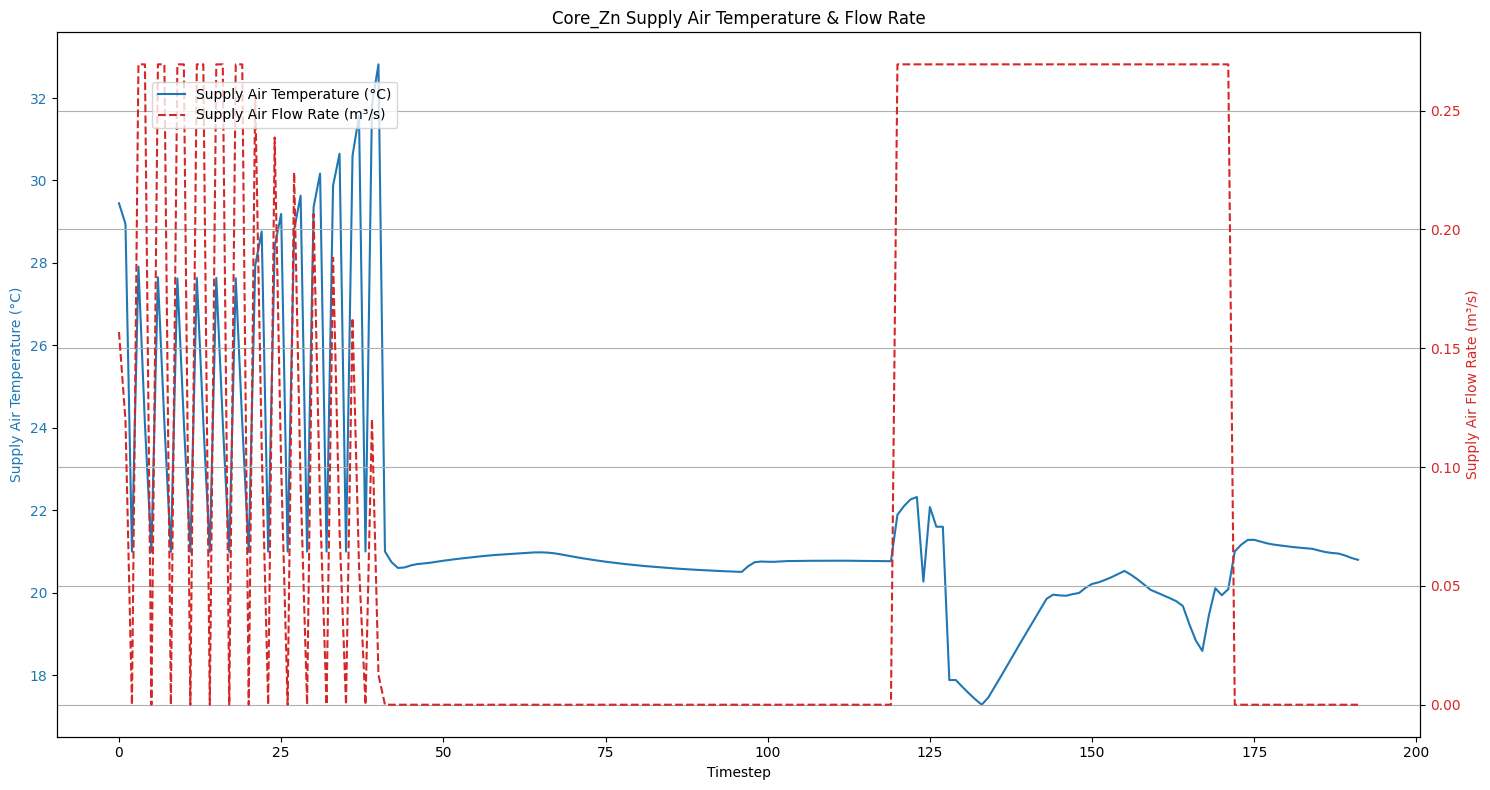

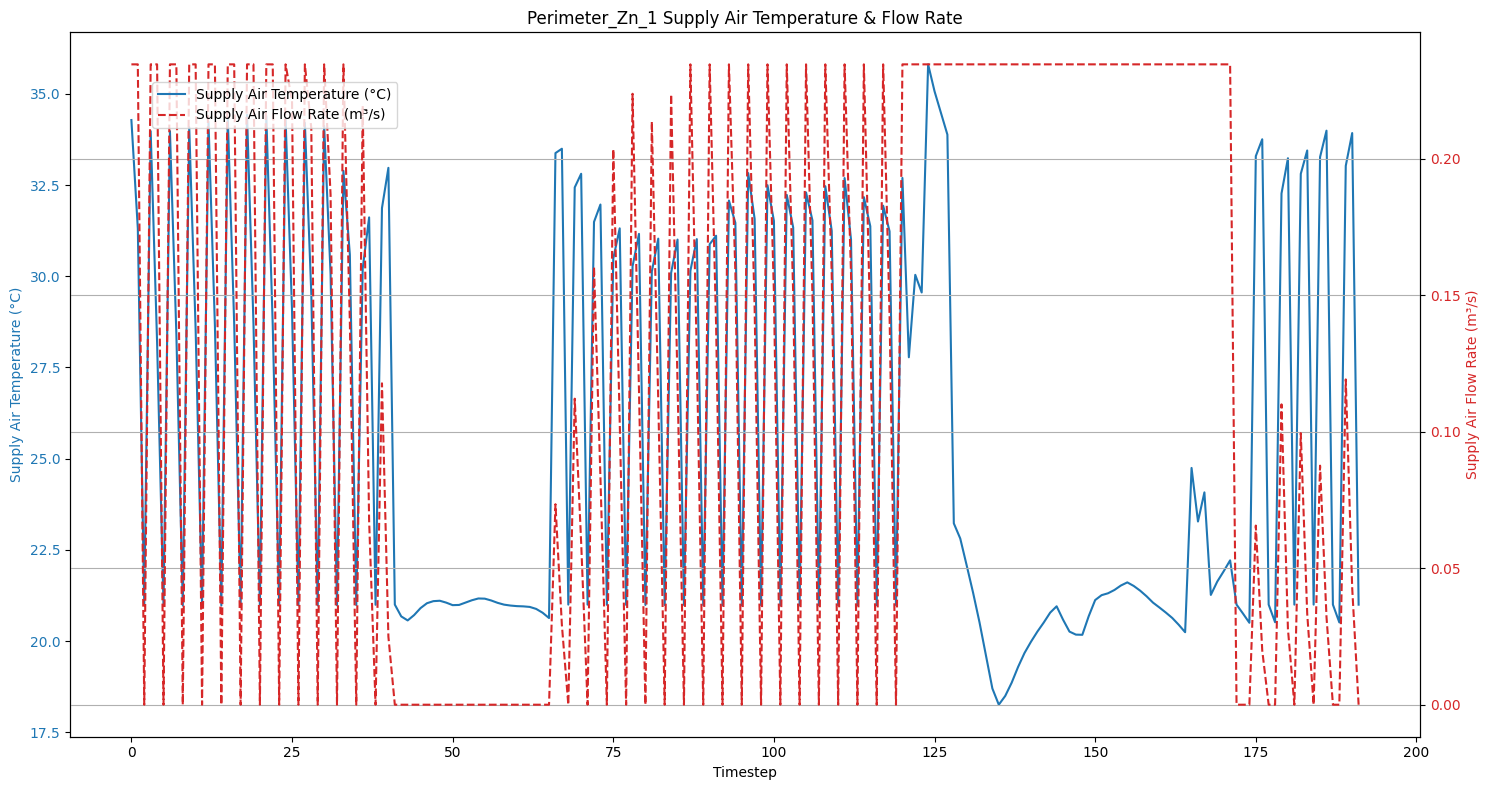

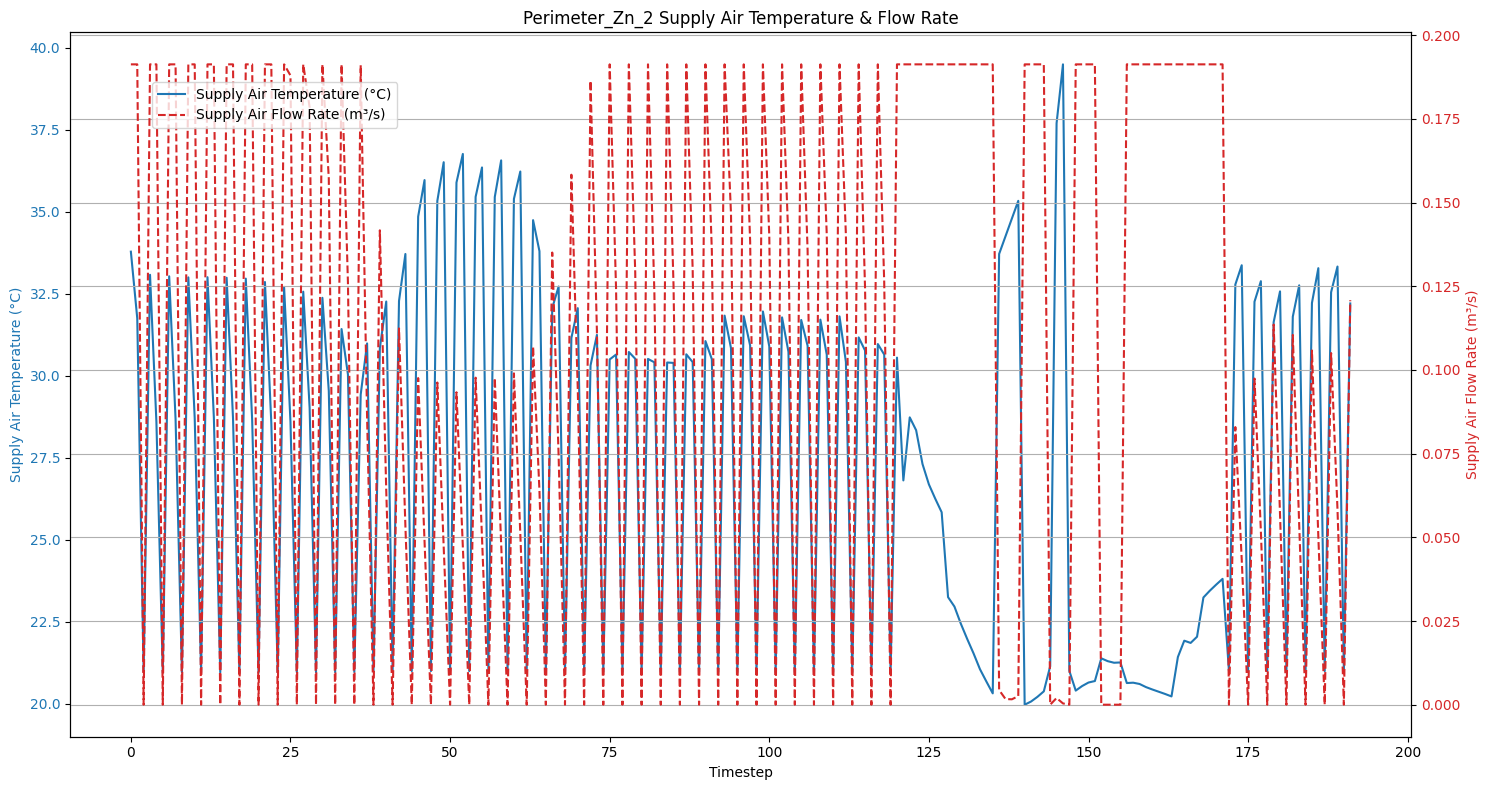

In [16]:
simulation.plot_supply_air("Core_Zn")
simulation.plot_supply_air("Perimeter_Zn_1")
simulation.plot_supply_air("Perimeter_Zn_2")

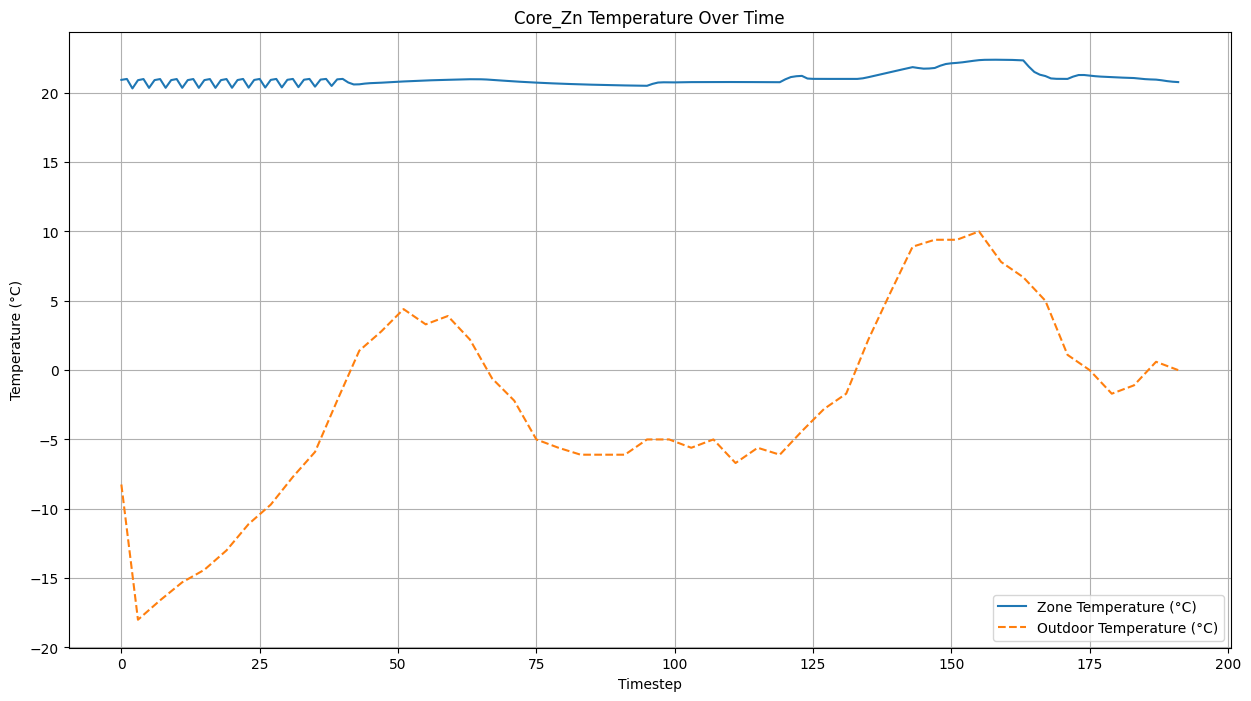

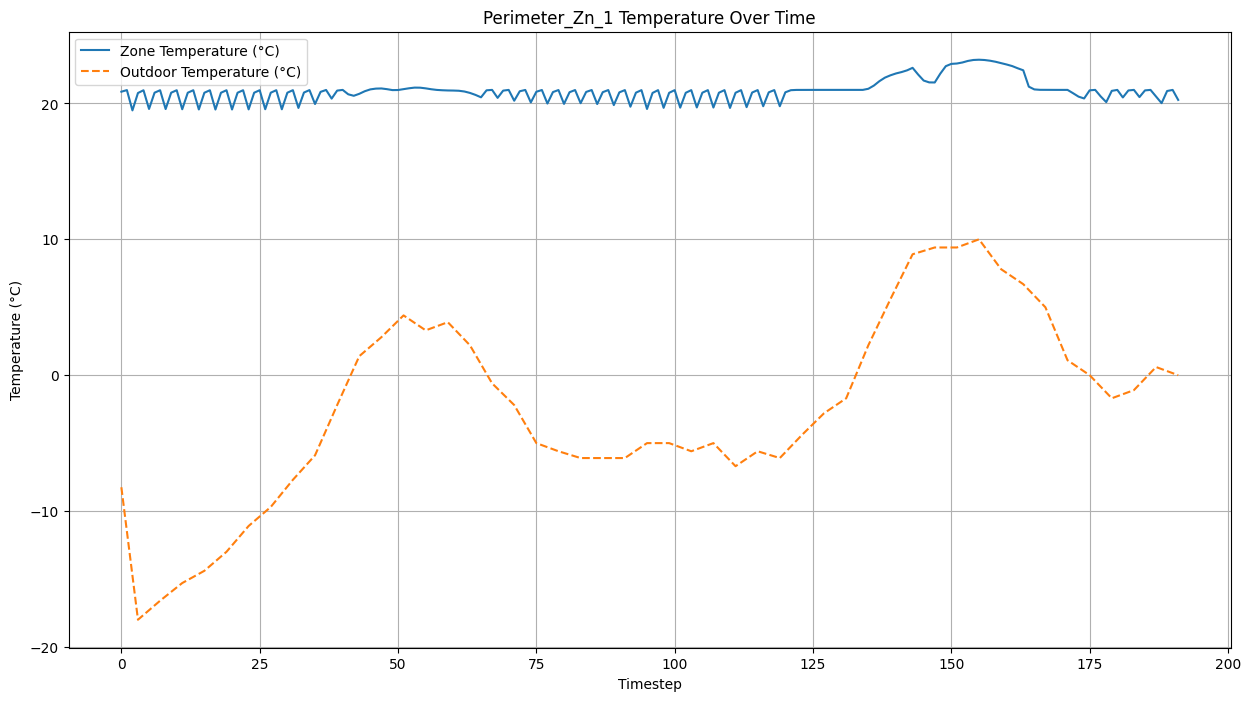

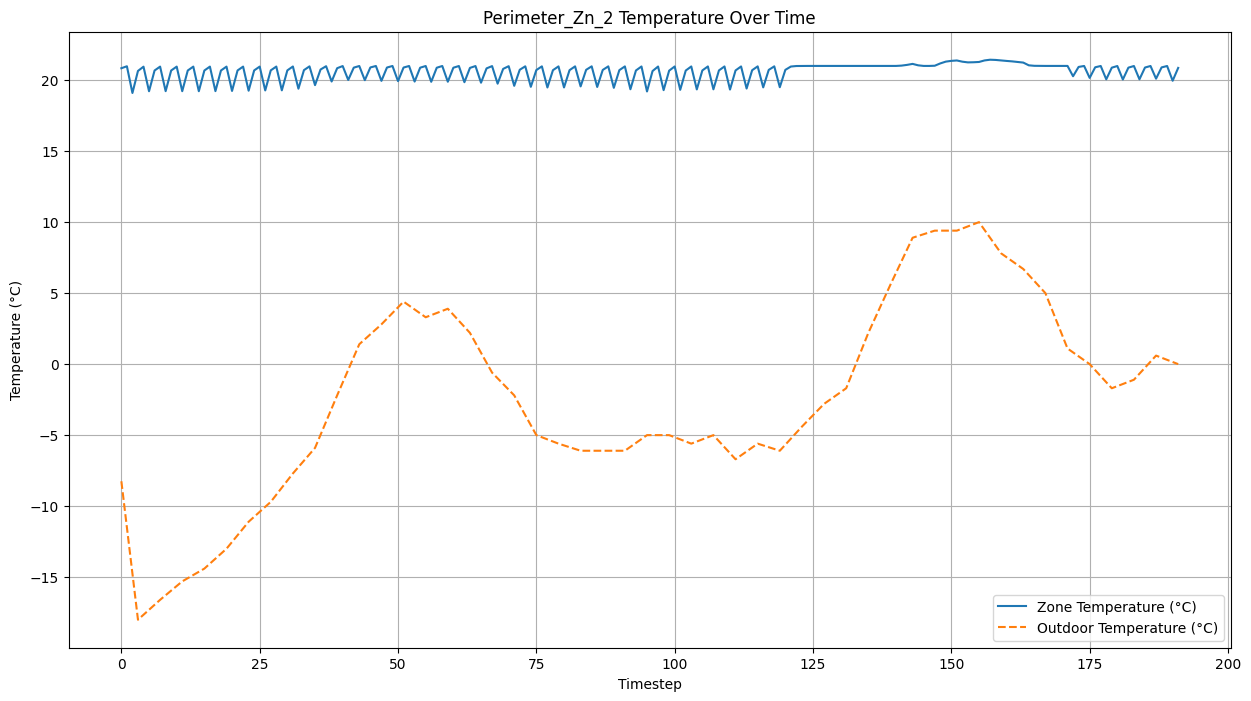

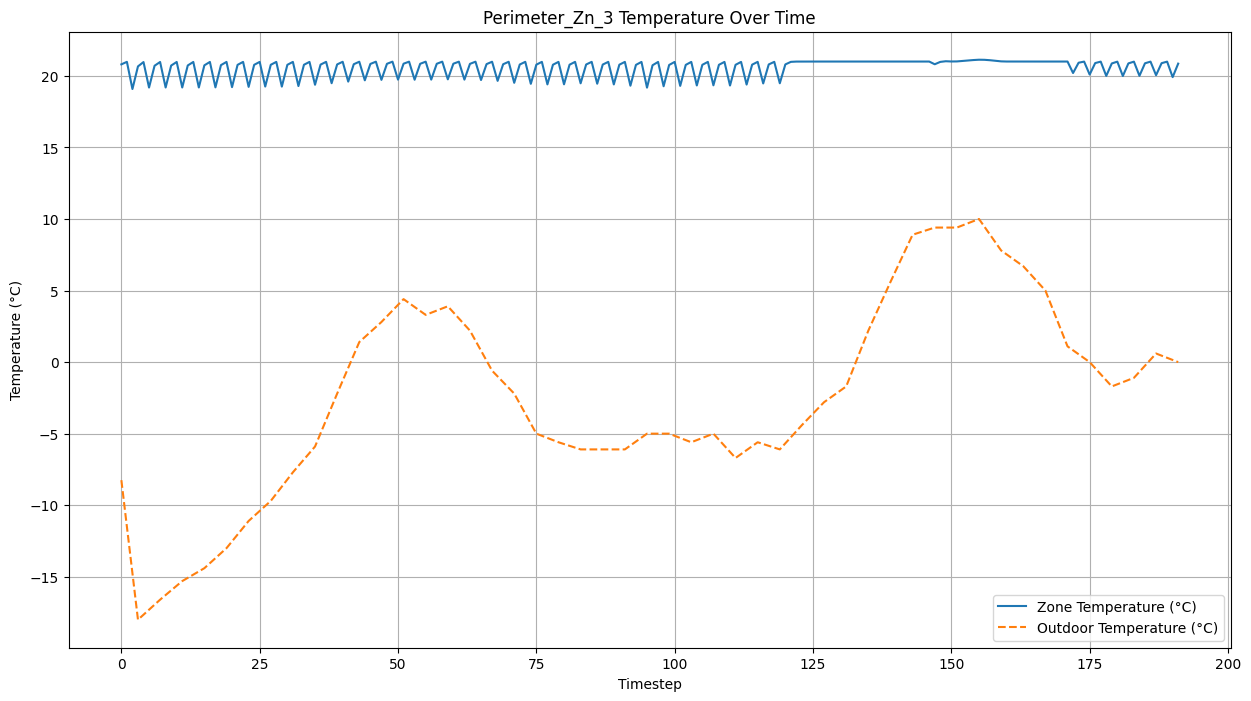

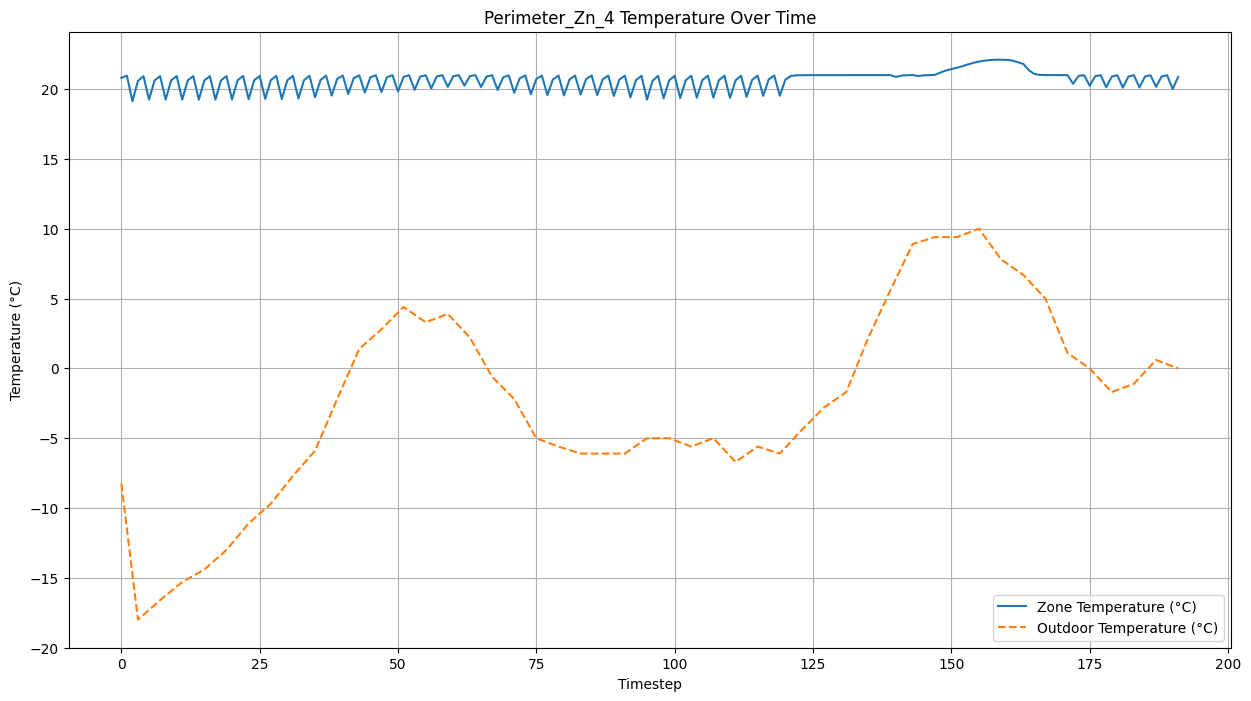

In [17]:
simulation.plot_temperatures("Core_Zn")
simulation.plot_temperatures("Perimeter_Zn_1")
simulation.plot_temperatures("Perimeter_Zn_2")
simulation.plot_temperatures("Perimeter_Zn_3")
simulation.plot_temperatures("Perimeter_Zn_4")

## Controlling supply air temperature and flow rate directly

In [ ]:
class Simulation:
    def __init__(self):
        self.api = EnergyPlusAPI()
        self.state = self.api.state_manager.new_state()
        
        self.zone_temperature_handles = None
        self.supply_air_temperature_handles = None
        self.supply_air_flow_rate_handles = None
        self.hvac_energy_handle = None
        
        self.zone_temperature_setpoint = 20.0 
        self.temperature_tolerance = 0.5 
        self.current_zone_temps = {}
        
        self.warmup_count = 0
        self.total_warmups = 3
        self.done_warmup = False
        self.get_handle_done = False

        self.min_supply_temp = 15.0  
        self.max_supply_temp = 40.0 

        self.zone_names = ["Core_Zn"] + [f"Perimeter_Zn_{i}" for i in range(1, 5)]

        self.memory = {
            "zone_temperature": {zone: [] for zone in self.zone_names},
            "supply_air_temperature": {zone: [] for zone in self.zone_names},
            "supply_air_flow_rate": {zone: [] for zone in self.zone_names},
            "pmv": {zone: [] for zone in self.zone_names},
            "hvac_energy": [],
            "heating_energy": [],
            "cooling_energy": [],
            "fan_energy": [],
            "outdoor_temperature": []
        }

    
    def get_actuator_handle(self):
    
        # self.supply_air_temperature_handles = {
        #     zone: self.api.exchange.get_actuator_handle(
        #         self.state,
        #         component_type="Schedule:Compact",
        #         control_type="Schedule Value",
        #         actuator_key=f"{zone}_Supply_Temp_Sch"
        #     ) for zone in self.zone_names
        # }

                
        self.supply_air_temperature_handles = {
            zone: self.api.exchange.get_actuator_handle(
                self.state,
                component_type="System Node Setpoint",
                control_type="Temperature Setpoint",
                actuator_key=f"PSZ-AC:{i+1} Supply Equipment Outlet Node"
            ) for i, zone in enumerate(self.zone_names)
        }

        print("Air temperature handles", self.supply_air_temperature_handles)


        # 0: Uncontrolled, 4: Dual setpoint
        self.thermostat_control_handle = self.api.exchange.get_actuator_handle(
            self.state,
            component_type="Schedule:Compact",
            control_type="Schedule Value",
            actuator_key="Dual Zone Control Type Sched" 
        )
        print("thermostat control handle", self.thermostat_control_handle)

        
        # self.supply_air_flow_rate_handles = {
        #     zone: self.api.exchange.get_actuator_handle(
        #         self.state,
        #         component_type="AirTerminal:SingleDuct:Uncontrolled",
        #         control_type="Air Mass Flow Rate",
        #         actuator_key=f"{zone} Air Terminal"
        #     ) for zone in self.zone_names
        # }


        self.supply_air_flow_rate_handles = {
            zone: self.api.exchange.get_actuator_handle(
                self.state,
                component_type="Schedule:Compact",
                control_type="Schedule Value",
                actuator_key=f"{zone}_HVACOperationSchd"
            ) for zone in self.zone_names
        }    

        print("supply air flow rate handles", self.supply_air_flow_rate_handles)

        self.clg_sp_handle = self.api.exchange.get_actuator_handle(
            self.state,
            component_type="Schedule:Compact",
            control_type="Schedule Value",
            actuator_key="CLGSETP_SCH_OFF"
        )
        self.htg_sp_handle = self.api.exchange.get_actuator_handle(
            self.state,
            component_type="Schedule:Compact",
            control_type="Schedule Value",
            actuator_key="HTGSETP_SCH_OFF"
        )

    def get_variable_handle(self):
        self.zone_temperature_handles = {
            zone: self.api.exchange.get_variable_handle(
                self.state,
                "Zone Mean Air Temperature", 
                zone
            ) for zone in self.zone_names
        }
        
        self.pmv_handles = {
            zone: self.api.exchange.get_variable_handle(
                self.state,
                "Zone Thermal Comfort Fanger Model PMV",
                zone
            ) for zone in self.zone_names
        }
        
        self.outlet_node_temperature_handle ={
            zone: self.api.exchange.get_variable_handle(
            self.state,
            "System Node Temperature",
            f"PSZ-AC:{i+1} Supply Equipment Outlet Node"
        ) for (i, zone) in enumerate(self.zone_names)
        }

        self.mass_flow_handle = {
            zone: self.api.exchange.get_variable_handle(
            self.state,
            "System Node Mass Flow Rate",
            f"PSZ-AC:{i+1} Supply Equipment Outlet Node" 
        ) for (i, zone) in enumerate(self.zone_names)
        }

        self.outdoor_temp_handle = self.api.exchange.get_variable_handle(
                self.state,
                variable_name="Site Outdoor Air Drybulb Temperature",
                variable_key="Environment"
            )
        
        self.hvac_energy_handle = self.api.exchange.get_meter_handle(self.state, "Electricity:HVAC")
        self.heating_energy_handle = self.api.exchange.get_meter_handle(self.state, "Heating:Electricity")
        self.cooling_energy_handle = self.api.exchange.get_meter_handle(self.state, "Cooling:Electricity")
        self.fan_energy_handle = self.api.exchange.get_meter_handle(self.state, "Fans:Electricity")

    
    def get_handles(self):
        if not self.get_handle_done:
            self.get_actuator_handle()
            self.get_variable_handle()
            self.get_handle_done = True

    def run(self, building: str, weather: str, results_path: str):
        def callback_warm_up(state):
            self.warmup_count += 1
            self.done_warmup = (self.warmup_count >= self.total_warmups)
            print(f"Warm-up iteration {self.warmup_count} - Warm-up done: {self.done_warmup}")

        def callback_end_timestep(state):
            if self.done_warmup:
                self.get_handles()
                
                for zone in self.zone_names:
                    zone_temp = self.api.exchange.get_variable_value(state, self.zone_temperature_handles[zone])
                    pmv = self.api.exchange.get_variable_value(state, self.pmv_handles[zone])
                    supply_air_temperature = self.api.exchange.get_variable_value(state, self.outlet_node_temperature_handle[zone])
                    supply_air_flow_rate = self.api.exchange.get_variable_value(state, self.mass_flow_handle[zone])
                    self.current_zone_temps[zone] = zone_temp
                    self.memory["zone_temperature"][zone].append(zone_temp)
                    self.memory["pmv"][zone].append(pmv)
                    self.memory["supply_air_temperature"][zone].append(supply_air_temperature)
                    self.memory["supply_air_flow_rate"][zone].append(supply_air_flow_rate)

                outdoor_temperature = self.api.exchange.get_variable_value(state, self.outdoor_temp_handle)
                
                # Energy meters                
                hvac_energy = self.api.exchange.get_meter_value(state, self.hvac_energy_handle) / 3600  # Convert to Wh
                heating_energy = self.api.exchange.get_meter_value(state, self.heating_energy_handle) / 3600  # Convert to Wh
                cooling_energy = self.api.exchange.get_meter_value(state, self.cooling_energy_handle) / 3600  # Convert to Wh
                fan_energy = self.api.exchange.get_meter_value(state, self.fan_energy_handle) / 3600  # Convert to Wh

                # Update memory
                self.memory["hvac_energy"].append(hvac_energy)
                self.memory["heating_energy"].append(heating_energy)
                self.memory["cooling_energy"].append(cooling_energy)
                self.memory["fan_energy"].append(fan_energy)
                self.memory["outdoor_temperature"].append(outdoor_temperature)

        def callback_start_timestep(state):
            if self.done_warmup:
                self.get_handles()

                # Turn zones to uncontrolled
                # self.api.exchange.set_actuator_value(state, self.thermostat_control_handle, 0)

                for i, zone in enumerate(self.zone_names):                                       

                    new_supply_temp = 40.0
                    fan_status = 0.0
                    
                    self.api.exchange.set_actuator_value(state, self.clg_sp_handle, 40.0)
                    self.api.exchange.set_actuator_value(state, self.htg_sp_handle, 10.0)
                    
                    self.api.exchange.set_actuator_value(state, self.supply_air_temperature_handles[zone], new_supply_temp)
                    self.api.exchange.set_actuator_value(state, self.supply_air_flow_rate_handles[zone], fan_status)
                    


        self.api.runtime.callback_after_new_environment_warmup_complete(self.state, callback_warm_up)
        self.api.runtime.callback_end_zone_timestep_after_zone_reporting(self.state, callback_end_timestep)
        self.api.runtime.callback_begin_system_timestep_before_predictor(self.state, callback_start_timestep)
        # self.api.runtime.callback_after_predictor_after_hvac_managers(self.state, callback_start_timestep)

        
        def eplus_thread():
            try:
                exit_code = self.api.runtime.run_energyplus(
                    self.state,
                    command_line_args=['-d', results_path, '-w', weather, building]
                )
                print(f"EnergyPlus finished with exit code {exit_code}")

                if exit_code != 0:
                    print("Critical error in EnergyPlus! Stopping execution.")
                    sys.exit(1)
            except Exception as e:
                print(f"EnergyPlus Simulation Error: {e}")
                traceback.print_exc()

        thread = threading.Thread(target=eplus_thread, daemon=True)
        thread.start()
        

    
    def plot_supply_air(self, zone):
        timesteps = range(len(self.memory["supply_air_temperature"][zone]))
    
        fig, ax1 = plt.subplots(figsize=(15, 8))
    
        # Plot supply air temperature on the primary y-axis
        ax1.plot(timesteps, self.memory["supply_air_temperature"][zone], color="tab:blue", label="Supply Air Temperature (°C)")
        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("Supply Air Temperature (°C)", color="tab:blue")
        ax1.tick_params(axis='y', labelcolor="tab:blue")
    
        # Create a second y-axis for supply air flow rate
        ax2 = ax1.twinx()
        ax2.plot(timesteps, self.memory["supply_air_flow_rate"][zone], color="tab:red", linestyle="dashed", label="Supply Air Flow Rate (m³/s)")
        ax2.set_ylabel("Supply Air Flow Rate (m³/s)", color="tab:red")
        ax2.tick_params(axis='y', labelcolor="tab:red")
    
        # Title and legend
        plt.title(f"{zone} Supply Air Temperature & Flow Rate")
        fig.tight_layout()
        fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    
        plt.grid()
        plt.show()


    def plot_temperatures(self, zone):
        timesteps = range(len(self.memory["zone_temperature"][zone]))

        plt.figure(figsize=(15, 8))
        
        plt.plot(timesteps, self.memory["zone_temperature"][zone], label="Zone Temperature (°C)")
        plt.plot(timesteps, self.memory["outdoor_temperature"], label="Outdoor Temperature (°C)", linestyle="--")
        plt.axhline(y=self.zone_temperature_setpoint, color="r", linestyle="--", label=f"Setpoint ({self.zone_temperature_setpoint}°C)")
        plt.fill_between(timesteps, self.zone_temperature_setpoint - self.temperature_tolerance,
        self.zone_temperature_setpoint + self.temperature_tolerance, color="red", alpha=0.2, label="Comfort Band (±0.5°C)")
        plt.xlabel("Timestep")
        plt.ylabel("Temperature (°C)")
        plt.title(f"{zone} Temperature Over Time")
        plt.legend()
        plt.grid()

    def plot_energy_consumption(self):

        timesteps = range(len(self.memory["hvac_energy"]))
        
        plt.figure(figsize=(12, 6))
        plt.plot(timesteps, self.memory["hvac_energy"], label="total HVAC")
        plt.plot(timesteps, self.memory["heating_energy"], label="heating")
        plt.plot(timesteps, self.memory["cooling_energy"], label="cooling")
        plt.plot(timesteps, self.memory["fan_energy"], label="fan")
        plt.legend()
        plt.xlabel("Timestep")
        plt.ylabel("Energy (Wh)")
        plt.grid()